In [100]:
import pandas as pd
import numpy as np

import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import datetime

from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon

from geopy.distance import geodesic
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="MJ")

# Specify the path to your text file
file_path = './timeline_to_excel.txt'

# Define the column names
columns = ['Country/State', 'Date entered', 'Date left', 'Time spent (days)']

# Load the data into a DataFrame
df = pd.read_csv(file_path, delimiter='\t', parse_dates=['Date entered', 'Date left'], names=columns, skiprows=1)
#df = pd.read_csv(file_path, names=columns)

loc_list = list(df['Country/State'])
time_spent = list(df['Time spent (days)'])

In [157]:
loc_dict = {}
visit_dict = {}

for loc, ts in zip(loc_list, time_spent):
    
    if loc not in loc_dict:
        loc_dict[loc] = ts
        visit_dict[loc] = 1
    else:
        loc_dict[loc] += ts
        visit_dict[loc] += 1
        
# count all transitions (leave out air)
trans_list = []
for i in range(len(loc_list) - 1):
    
    start = loc_list[i]
    
    if start == 'Air':
        continue
        
    if loc_list[i+1] == 'Air':
        end = loc_list[i+2]
        
    else:
        end = loc_list[i+1]
        
    trans_list.append([start, end])
    
print(loc_dict)
print(trans_list)

{'Michigan': 10.4472222224, 'Indiana': 0.8333333333900002, 'Illinois': 183.58333331626, 'Air': 3.4166666667200003, 'Mexico': 3.5, 'Colombia': 25.197916667, 'Panama': 3.114583333, 'Wisconsin': 1.4791666662999998, 'Maryland': 4.510416667, 'Colorado': 4.354166667, 'Iowa': 0.6979166666, 'Nebraska': 0.40624999997, 'Utah': 2.5, 'Arizona': 0.02083333334, 'Nevada': 1.41666666674, 'California': 79.69791667004, 'Washington': 3.791666667, 'Idaho': 0.08333333334, 'Wyoming': 2.2395833336699997, 'Montana': 0.8541666667, 'South Dakota': 1.9375, 'Minnesota': 1.114583333, 'Virginia': 0.09375, 'DC': 0.052083333339999996, 'Florida': 4.34375, 'Texas': 0.05208333334, 'New Zealand': 10.14583333, 'Connecticut': 11.156250001, 'New York': 2.9583333329999997, 'Massachusetts': 1.0}
[['Michigan', 'Indiana'], ['Indiana', 'Illinois'], ['Illinois', 'Mexico'], ['Mexico', 'Colombia'], ['Colombia', 'Panama'], ['Panama', 'Colombia'], ['Colombia', 'Mexico'], ['Mexico', 'Illinois'], ['Illinois', 'Wisconsin'], ['Wisconsin'

In [228]:
sorted_loc_dict = dict(sorted(loc_dict.items(), key=lambda item: item[1], reverse=True))

legend_text = ''

for loc, ts in sorted_loc_dict.items():
    if ts >= 1.0:
        print(loc.ljust(10), '\t', np.round(ts, 1), 'days', f'   ({visit_dict[loc]} visits)')
        legend_text += f'{loc.ljust(12)} {np.round(ts, 1)} days\n' # ({visit_dict[loc]} visits)\n'
    elif ts >= 1.0/24:
        print(loc.ljust(10), '\t', np.round(ts*24, 1), 'hours', f'  ({visit_dict[loc]} visits)')
        legend_text += f'{loc.ljust(12)} {np.round(ts*24, 1)} hours\n' # ({visit_dict[loc]} visits)\n'
    else:
        print(loc.ljust(10), '\t', np.round(ts*24*60, 0), 'minutes', f'({visit_dict[loc]} visits)')
        legend_text += f'{loc.ljust(12)} {np.round(ts*24*60, 0)} minutes\n' # ({visit_dict[loc]} visits)\n'

Illinois   	 183.6 days    (14 visits)
California 	 79.7 days    (6 visits)
Colombia   	 25.2 days    (2 visits)
Connecticut 	 11.2 days    (4 visits)
Michigan   	 10.4 days    (7 visits)
New Zealand 	 10.1 days    (1 visits)
Maryland   	 4.5 days    (2 visits)
Colorado   	 4.4 days    (2 visits)
Florida    	 4.3 days    (1 visits)
Washington 	 3.8 days    (1 visits)
Mexico     	 3.5 days    (2 visits)
Air        	 3.4 days    (21 visits)
Panama     	 3.1 days    (1 visits)
New York   	 3.0 days    (2 visits)
Utah       	 2.5 days    (2 visits)
Wyoming    	 2.2 days    (2 visits)
South Dakota 	 1.9 days    (1 visits)
Wisconsin  	 1.5 days    (2 visits)
Nevada     	 1.4 days    (5 visits)
Minnesota  	 1.1 days    (1 visits)
Massachusetts 	 1.0 days    (1 visits)
Montana    	 20.5 hours   (1 visits)
Indiana    	 20.0 hours   (12 visits)
Iowa       	 16.7 hours   (2 visits)
Nebraska   	 9.7 hours   (2 visits)
Virginia   	 2.2 hours   (2 visits)
Idaho      	 2.0 hours   (1 visits)
Texas   

In [229]:
# add color coded map with transition matrix?

# set visits to each hood ot zero
path_to_shp = '../shape_files/cb_2018_us_state_5m/cb_2018_us_state_5m.shp'
gdf = gpd.read_file(path_to_shp)

visits_all = []
com_all = []
com_dict = {}

for state, poly in zip(gdf['NAME'], gdf['geometry']):
    if state == 'District of Columbia':
        state = 'DC'
    
    # update visits for all stat
    if state in sorted_loc_dict:
        visits_all.append(sorted_loc_dict[state])
    else:
        visits_all.append(0)
        
    # get center of mass based on polygon for all states
    try: coordinates = poly.exterior.coords
    except: coordinates = np.concatenate([p.exterior.coords for p in poly])
    
    mean_coordinates = (
        sum(coord[0] for coord in coordinates) / len(coordinates),
        sum(coord[1] for coord in coordinates) / len(coordinates)
    )
    
    com_dict[state] = mean_coordinates
    com_all.append(mean_coordinates)
    
    com_dict[state] = mean_coordinates

gdf['visits'] = np.array(visits_all)
gdf['com_lat'] = np.array(com_all)[:, 0]
gdf['com_lon'] = np.array(com_all)[:, 1]

C:\Users\mrjon\AppData\Local\Temp\ipykernel_380\4270460310.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  except: coordinates = np.concatenate([p.exterior.coords for p in poly])


In [243]:
# override coords and specify for non-USA

com_dict['New Zealand'] = (-125, 30)
com_dict['Panama'] = (-120, 26)
com_dict['Colombia'] = (-114, 24)
com_dict['Mexico'] = (-106, 26)
com_dict['Michigan'] = (-85, 43)
com_dict['Florida'] = (-82, 28)
com_dict['Illinois'] = (-89, 41)
com_dict['Indiana'] = (-86, 40)
com_dict['Maryland'] = (-76.5, 39.5)

In [244]:
# Create LineString geometries connecting the two sets of points
arrows = []

for [start, end] in trans_list:
    
    try:
        start_coord = com_dict[start]
        end_coord = com_dict[end]
        arrows.append(LineString([start_coord, end_coord]))
        
    except:
        print(start, end, 'failed')

# Create GeoDataFrame for arrows
arrows_gdf = gpd.GeoDataFrame(geometry=arrows)

print(arrows_gdf)

                                             geometry
0   LINESTRING (-85.00000 43.00000, -86.00000 40.0...
1   LINESTRING (-86.00000 40.00000, -89.00000 41.0...
2   LINESTRING (-89.00000 41.00000, -106.00000 26....
3   LINESTRING (-106.00000 26.00000, -114.00000 24...
4   LINESTRING (-114.00000 24.00000, -120.00000 26...
..                                                ...
77  LINESTRING (-72.83817 41.42314, -74.67860 42.5...
78  LINESTRING (-74.67860 42.50285, -72.83817 41.4...
79  LINESTRING (-72.83817 41.42314, -89.00000 41.0...
80  LINESTRING (-89.00000 41.00000, -86.00000 40.0...
81  LINESTRING (-86.00000 40.00000, -85.00000 43.0...

[82 rows x 1 columns]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


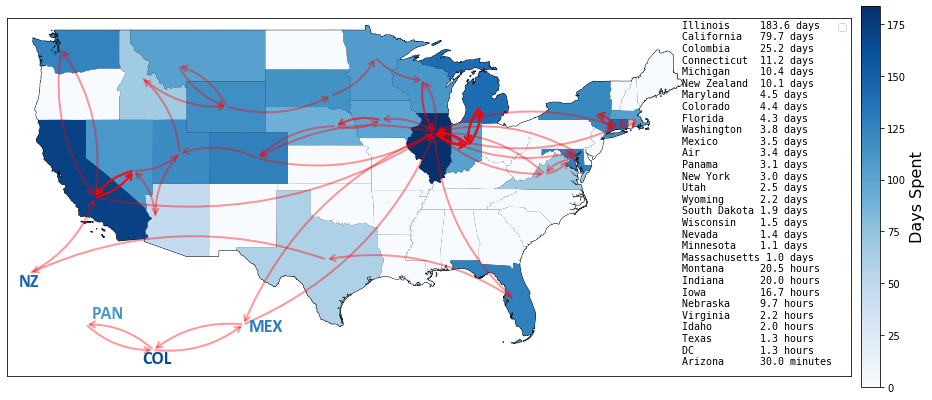

In [269]:

from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

# scatter all locatoins
fig, axes = plt.subplots(figsize=(18, 14), sharex=True, sharey=True)
gdf.plot(ax=axes, color='lightcyan', edgecolor='black')

# color hoods
gdf['log_visits'] = np.log(gdf['visits'] + .001)
gdf.plot(ax=axes, column='log_visits', legend=False, cmap='Blues')

norm = Normalize(vmin=gdf['visits'].min(), vmax=gdf['visits'].max())
sm = ScalarMappable(norm=norm, cmap='Blues')

cbar = fig.colorbar(sm, ax=axes, shrink=0.5, pad=0.01)
cbar.set_label('Days Spent', fontsize=16)

for i, arrow in arrows_gdf.iterrows():
    coords = list(arrow['geometry'].coords)
    
    # Create a FancyArrowPatch object
    curved_arrow = FancyArrowPatch(
        coords[0], coords[1], 
        connectionstyle="arc3,rad=.2", # This creates a curved line with a radius of curvature
        arrowstyle='->,head_length=5,head_width=3', 
        color='red', 
        linewidth=2, 
        linestyle='solid',
        alpha=0.4
    )
    
    # Add it to the axes
    axes.add_patch(curved_arrow)
    
# center of mass of each state
#axes[0].scatter(gdf['com_lat'], gdf['com_lon'], marker='o', c='red')


# set chicago limits:
axes.set_xlim(-127, -52)
axes.set_ylim(22, 50)
    
axes.legend()
axes.annotate(legend_text, (-67, 21.97), family='monospace')

blue_spectrum = [cm.get_cmap('Blues')(i / 10) for i in range(10)]

axes.annotate('NZ', np.array(com_dict['New Zealand'])-1.0, c=blue_spectrum[8], fontname='Calibri', fontsize=18, weight='bold')
axes.annotate('PAN', np.array(com_dict['Panama'])+0.5, c=blue_spectrum[6], fontname='Calibri', fontsize=18, weight='bold')
axes.annotate('COL', np.array(com_dict['Colombia'])-1.0, c=blue_spectrum[9], fontname='Calibri', fontsize=18, weight='bold')
axes.annotate('MEX', np.array(com_dict['Mexico'])+np.array([0.5, -0.5]), c=blue_spectrum[7], fontname='Calibri', fontsize=18, weight='bold')

# Remove ticks from x and y axes
axes.tick_params(axis='both', which='both', bottom=False, top=False, 
                 left=False, right=False, labelbottom=False,  labelleft=False)     
